In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from copy import copy, deepcopy
import tensorflow as tf

C:\Users\mclapp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mclapp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mclapp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mclapp\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: P

In [57]:
# c1=0.5 for all environments
# maxEnv: c2=1.0
# highEnv: c2=0.5
# medEnv: c2=0.0
# negEnv: c2=-0.5
# minEnv: c2=-1.0 


# helper functions to generate the inputs/outputs for each environment
# the hardcoded tables only encode half of the data for each environment

# usage:
# batch_x, batch_y = batchData(medEnv())
# VERY IMPORTANT NOTE: each time it is called, it returns the data for that environment.
# The first half of the batch all of the entries with identity (as in, target output) of 0.
# Second half is all entries with identity 1.
# The entries in the first and second half are shuffled.
# This functionality is used to pair inputs with other inputs with the same identity, by calling it twice.

def batchData(env):
    batch_x = []
    batch_y = []
    for i in range(len(env)):
        batch_x.append(env[i][1:])
        batch_y.append([env[i][0]])
    return (batch_x, batch_y)

def flipEnv(env):
    random.shuffle(env)
    length = len(env)
    for i in range(length):
        env.append([1-v for v in env[i]])
    return env

def maxEnvHalf():
    return [
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,1,0],
        [0,1,0],
        [0,1,0],
        [0,1,0]
    ]

def maxEnv():
    return flipEnv(maxEnvHalf())

def highEnvHalf():
    return [
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,1],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,1],
        [0,0,0],
        [0,0,0],
        [0,0,0],
        [0,0,1],
        [0,1,0],
        [0,1,0],
        [0,1,0],
        [0,1,1]
    ]

def highEnv():
    return flipEnv(highEnvHalf())

def medEnvHalf():
    return [
        [0,0,0],
        [0,0,0],
        [0,0,1],
        [0,0,1],
        [0,0,0],
        [0,0,0],
        [0,0,1],
        [0,0,1],
        [0,0,0],
        [0,0,0],
        [0,0,1],
        [0,0,1],
        [0,1,0],
        [0,1,0],
        [0,1,1],
        [0,1,1]
    ]


def medEnv():
    return flipEnv(medEnvHalf())

def negEnvHalf():
    return [
        [0,0,0],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,0],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,0],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,1,0],
        [0,1,1],
        [0,1,1],
        [0,1,1]
    ]

def negEnv():
    return flipEnv(negEnvHalf())

def minEnvHalf():
    return [
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,0,1],
        [0,1,1],
        [0,1,1],
        [0,1,1],
        [0,1,1]
    ]

def minEnv():
    return flipEnv(minEnvHalf())

In [5]:
learning_rate = 0.5

In [6]:
layer0 = tf.placeholder(tf.float32, [None, 2])
targ = tf.placeholder(tf.float32, [None, 1])

In [7]:
# deeper network:
# the naming conventions are all screwed up b/c this is revision 15 of the code 
# input layer (layer0): 2 units
# extra hidden layer (layerp): 5 units
# invariance layer (layer1): 3 units
# output layer (layer4): 1 unit 
# the first half of the network is input -> invariance layer
# the second half is invariance layer -> output
# when classifying inputs, both halves act together

if True:
    l1width = 3

    lpwidth = 5

    Wp = tf.Variable(tf.random_normal([2, lpwidth], stddev=0.03), name='W1')
    bp = tf.Variable(tf.random_normal([lpwidth]), name='b1')

    W1 = tf.Variable(tf.random_normal([lpwidth, l1width], stddev=0.03), name='W1')
    b1 = tf.Variable(tf.random_normal([l1width]), name='b1')


    W4 = tf.Variable(tf.random_normal([l1width, 1], stddev=0.03), name='W4')
    b4 = tf.Variable(tf.random_normal([1]), name='b4')

    layerp = tf.nn.softmax(tf.add(tf.matmul(layer0, Wp), bp))
    layer1 = tf.nn.softmax(tf.add(tf.matmul(layerp, W1), b1))
    layer4 = tf.add(tf.matmul(layer1, W4), b4)

In [8]:
# shallow network:
# input layer (layer0): 2 units
# invariance layer (layer1): 3 units
# output layer (layer4): 1 unit
# this network sometimes doesn't converge as good as the deeper net

if False:
    l1width = 3

    W1 = tf.Variable(tf.random_normal([2, l1width], stddev=0.03), name='W1')
    b1 = tf.Variable(tf.random_normal([l1width]), name='b1')

    W4 = tf.Variable(tf.random_normal([l1width, 1], stddev=0.03), name='W4')
    b4 = tf.Variable(tf.random_normal([1]), name='b4')

    layer1 = tf.nn.softmax(tf.add(tf.matmul(layer0, W1), b1))
    layer4 = tf.add(tf.matmul(layer1, W4), b4)

In [17]:
# primary gradient descent on whole network
# for each example:
# the values of the input layer are set
# there are targets values for the output layer

loss = tf.reduce_mean(tf.square(layer4 - targ))
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate/1).minimize(loss)

In [18]:
# gradient descent on first half... notice the - sign in .minimize(-invloss)
# for each example:
# the values of the input layer are set
# there are targets values for the invariant layer

invtarg = tf.placeholder(tf.float32, [None, l1width])
invloss = tf.reduce_mean(tf.square(layer1 - invtarg))
invoptimaxer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate/5).minimize(-invloss)

In [19]:
# gradient descent on second half
# a "mock" version of the second half of the network is created,
# using the same weight and bias tensors as the actual network
# but with the first network half replaced by a placeholder for the invariant layer 
# for each example:
# the values of the invariant layer are set
# there are targets values for the mock output layer

invph = tf.placeholder(tf.float32, [None, l1width])
mockl4 = tf.add(tf.matmul(invph, W4), b4)
classloss = tf.reduce_mean(tf.square(mockl4 - targ))
classoptimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate/5).minimize(classloss)

In [13]:
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()

In [53]:
# how many times to repeat each environment before cycling to the next one
# just to prove that it doesn't rely on the environment always changing every epoch
envreps = 2

allscores = []

# start the session
with tf.Session() as sess:
    # initialise the variables
    sess.run(init_op)
    
    for epoch in range(800):
        if epoch % (2*envreps) < envreps:
            batch_x, batch_y = batchData(medEnv())
            batch_x_shuffledbyidentity, _ = batchData(medEnv())
        else:
            batch_x, batch_y = batchData(highEnv())
            batch_x_shuffledbyidentity, _ = batchData(highEnv())
        
        for loop in range(5):
            # normal gradient descent
            sess.run(optimiser, feed_dict={layer0: batch_x, targ: batch_y})
        
        # get the invariant layer activations for each input
        invlayer = sess.run(layer1, feed_dict={layer0: batch_x})
        
        # get the invariant layer and output layer activations for each input, shuffled within each identity
        invlayer_shuffledbyidentity, outlayer_shuffledbyidentity = sess.run([layer1,layer4], 
                                                                            feed_dict={layer0: batch_x_shuffledbyidentity}) 
        
        for loop in range(5):
            # secondary gradient descents
            # comment these two lines out to see network performance with just normal backprop
            sess.run(invoptimaxer, feed_dict={layer0: batch_x, invtarg: invlayer_shuffledbyidentity})
            sess.run(classoptimiser, feed_dict={invph: invlayer, targ: outlayer_shuffledbyidentity})
            pass
        
        # test on all 5 environments
        epochscore = []
        batch_x, batch_y = batchData(minEnv())
        epochscore.append(sess.run(loss, feed_dict={layer0: batch_x, targ: batch_y}))
        batch_x, batch_y = batchData(negEnv())
        epochscore.append(sess.run(loss, feed_dict={layer0: batch_x, targ: batch_y}))
        batch_x, batch_y = batchData(medEnv())
        epochscore.append(sess.run(loss, feed_dict={layer0: batch_x, targ: batch_y}))
        batch_x, batch_y = batchData(highEnv())
        epochscore.append(sess.run(loss, feed_dict={layer0: batch_x, targ: batch_y}))
        batch_x, batch_y = batchData(maxEnv())
        epochscore.append(sess.run(loss, feed_dict={layer0: batch_x, targ: batch_y}))
        allscores.append(epochscore)


allscoresT = np.array(allscores).T.tolist()

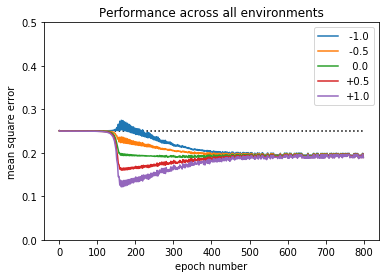

In [54]:
# a mean square error of 0.25 represents a network which outputs a constant 0.5 (the two possible labels are 0 and 1)

plt.ylim(0,0.5)
plt.title('Performance across all environments')
plt.xlabel('epoch number')
plt.ylabel('mean square error')
plt.hlines(0.25,0,800, linestyles='dotted')
p1, = plt.plot([i for i in range(len(allscores))],allscoresT[0])
p2, = plt.plot([i for i in range(len(allscores))],allscoresT[1])
p3, = plt.plot([i for i in range(len(allscores))],allscoresT[2])
p4, = plt.plot([i for i in range(len(allscores))],allscoresT[3])
p5, = plt.plot([i for i in range(len(allscores))],allscoresT[4])
plt.legend([p1, p2, p3, p4, p5], [' -1.0', ' -0.5', '  0.0', '+0.5', '+1.0'])

In [56]:
# errors for the 5 environments, averaged across the last 20 epochs
print(sum(allscoresT[0][-20:])/20)
print(sum(allscoresT[1][-20:])/20)
print(sum(allscoresT[2][-20:])/20)
print(sum(allscoresT[3][-20:])/20)
print(sum(allscoresT[4][-20:])/20)

0.19428520202636718
0.19366843700408937
0.19305167347192764
0.19243490770459176
0.19181814044713974
